# Dark Matter Model Creation/Implementation

## Intro

This script details the files how we constructed the dark matter models within the package and finally how to construct them more easily with the package. We will start with extracting the default branching fractions/annihilation ratios for the Z2 dark matter (scalar singlet), then looking at the individual final state spectra and then finally how these are combined. 

## Needed Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from scipy import interpolate, integrate
import pkg_resources
from gammabayes.utils import resources_dir
from gammabayes.dark_matter.channel_spectra import single_channel_spectral_data_path

plt.rc('font', family='serif')

darkSUSY_to_PPPC_converter = {
    "nuenue":"nu_e",
    "e+e-": "e",
    "numunumu":"nu_mu",
    "mu+mu-":"mu",
    'nutaunutau':"nu_tau",
    "tau+tau-":"tau",
    "uu":"u",
    "dd":"d",
    "cc": "c",
    "ss":"s",
    "tt": "t",
    "bb": "b",
    "gammagamma": "gamma",
    "W+W-": "W",
    "ZZ": "Z",
    "gg": "g",
    "HH": "h",
}

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_99256/1716079485.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extracting Annihilation Ratios

As stated, we first extract the default branching fractions from the package data

In [2]:
# df = pd.DataFrame(splitBFs, columns=list(variablesdict.values()))
import pandas
df = pandas.read_csv(resources_dir+'/../dark_matter/models/Z2_ScalarSinglet/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

Let's have a look at the first few rows of this dataframe.

In [3]:
df.head()

,Unnamed: 0,mS [GeV],lahS,nuenue,e+e-,numunumu,mu+mu-,nutaunutau,tau+tau-,uu,...,ss,tt,bb,gammagamma,W+W-,ZZ,gg,HH,Zgamma,hadrons (below confinement scale)
0,0,10.000000,0.001,0.0,1.037885e-39,0.0,4.436524e-35,0.0,1.196134e-32,1.073177e-37,...,1.264836e-34,0.0,1.890770e-31,0.000000e+00,0.000000e+00,0.000000e+00,8.482884e-34,0.0,0.0,0.0
1,1,10.469364,0.001,0.0,1.043123e-39,0.0,4.393279e-35,0.0,1.214077e-32,1.078593e-37,...,6.854531e-35,0.0,1.602054e-31,9.126824e-36,1.497633e-38,4.921968e-39,4.920581e-33,0.0,0.0,0.0
2,2,10.960759,0.001,0.0,1.048910e-39,0.0,4.415623e-35,0.0,1.224938e-32,1.084576e-37,...,6.799670e-35,0.0,1.613466e-31,1.006735e-35,1.991383e-38,6.538493e-39,4.635692e-33,0.0,0.0,0.0
3,3,11.475218,0.001,0.0,1.055308e-39,0.0,4.441829e-35,0.0,1.236346e-32,1.091192e-37,...,6.751376e-35,0.0,1.622866e-31,1.110078e-35,2.647259e-38,8.679740e-39,4.374268e-33,0.0,0.0,0.0
4,4,12.013824,0.001,0.0,1.062388e-39,0.0,4.470025e-35,0.0,1.248342e-32,1.098514e-37,...,6.709502e-35,0.0,1.630465e-31,1.224071e-35,3.523847e-38,1.153861e-38,4.137802e-33,0.0,0.0,0.0


You can see that the first two columns are the values of mass in GeV and the higgs coupling values for the differential cross-sections in the following columns with the final state in the header of each column. 

Let's extract the mass and coupling values (converting the mass into TeV while we're it).

In [4]:
massvalues = np.unique(df.iloc[:,1])/1000
lambdavalues = np.unique(df.iloc[:,2])

In [5]:
massvalues[0], massvalues[-1]

(0.01, 1046.9364459462731)

Now let's have a look at the values of these differential cross-sections using `matplotlib.pyplot.pcolormesh`. This may take up to a minute.

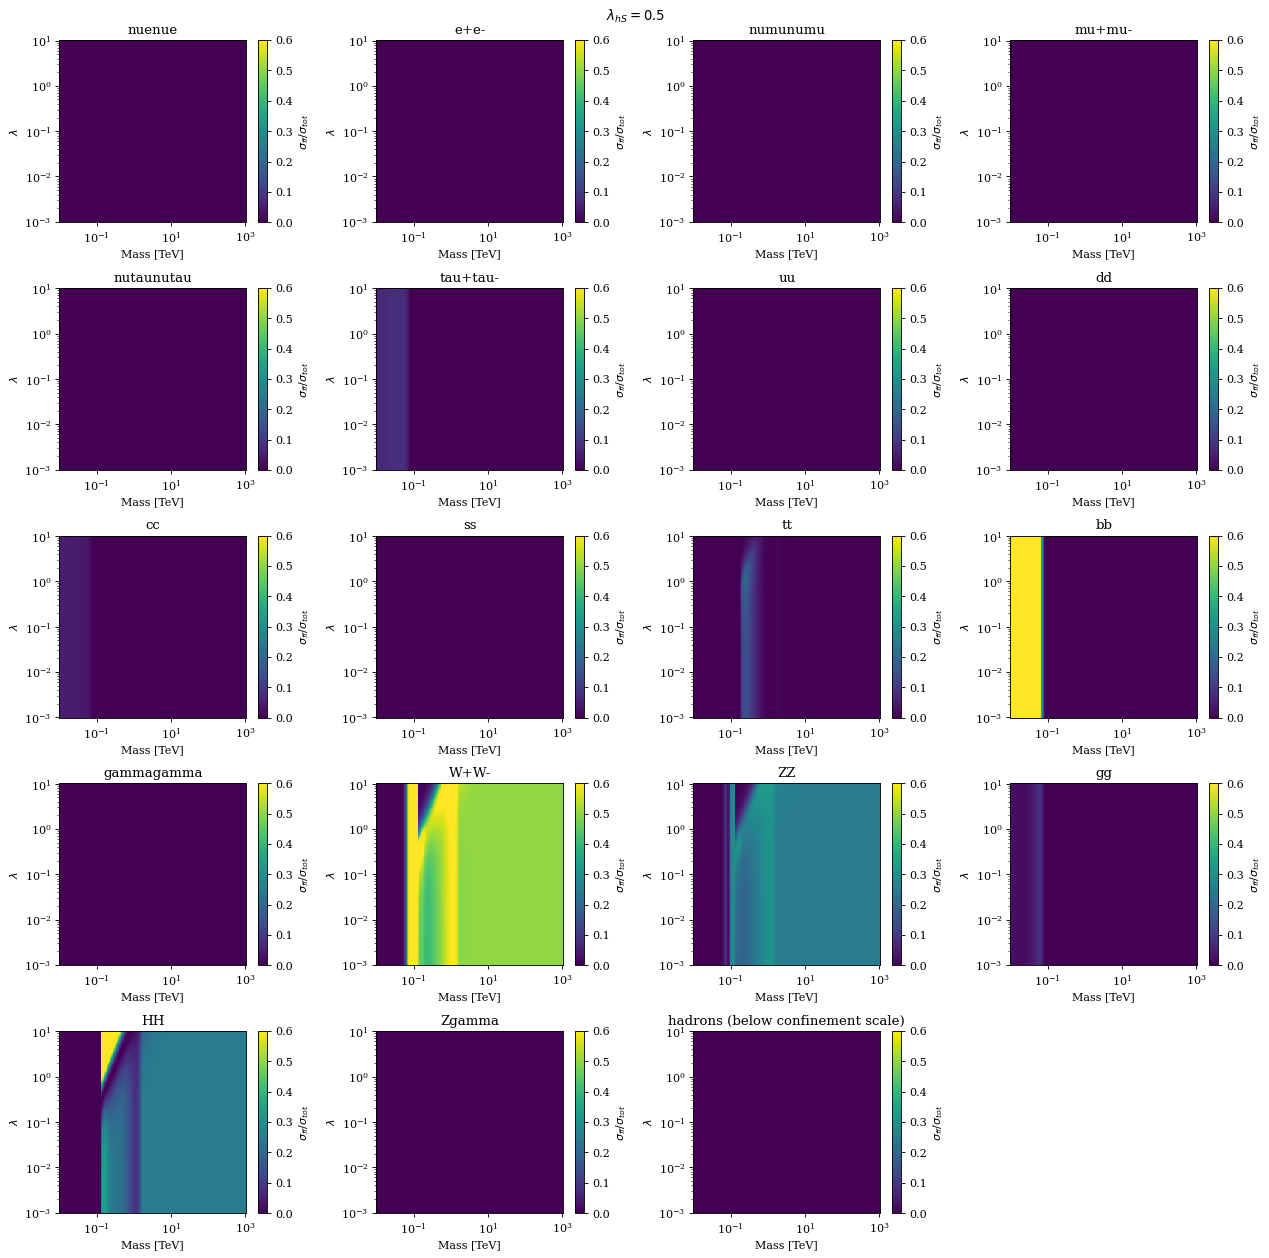

In [6]:
plt.figure(figsize=(16,16), dpi=80)
plt.suptitle(r"$\lambda_{hS}=0.5$")
massesabove0p1TeV = massvalues[massvalues>0.1]
for idx, channel_name in enumerate(list(df.columns)[3:]):
    plt.subplot(5,4, idx+1)
    plt.title(f"{channel_name}")
    plt.pcolormesh(massvalues, lambdavalues, 
                   (df.to_numpy()[:,idx+3]/np.sum(df.to_numpy()[:,3:],axis=1)).reshape(lambdavalues.shape[0], massvalues.shape[0]), vmin=0, vmax=0.6)#,
                #    norm=LogNorm(vmin=1e-50))
    plt.xlabel('Mass [TeV]')
    plt.ylabel(r'$\lambda$')
    plt.loglog()
    plt.colorbar(label=r'$\sigma_{ff}/\sigma_{tot}$')
plt.tight_layout()
plt.savefig('Figures/DM_Annihilation_Ratios_meshplots.pdf')
plt.show()

We can see that there are 4 'main' channels, the 'bb' channel for lower masses, then the 'W+W-', 'HH', and 'ZZ' channels for mass above ~0.08 TeV as we would want.


Now let's store these in a more user-friendly data structure, a dictionary where all the keys are the names of the channels as they are in darkSUSY and the values being functions that take in mass and coupling inputs and return the differential cross-section

In [7]:
import sys
from gammapy.astro.darkmatter import (
    profiles,
    JFactory
)
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import Map, MapAxis, MapAxes, WcsGeom


from gammabayes.utils.event_axes import energy_true_axis, longitudeaxistrue, latitudeaxistrue

darkSUSY_BFs_cleaned_vals = df.to_numpy()[:,3:]
partial_sigmav_interpolator_dictionary = {
    channel: interpolate.LinearNDInterpolator(
        (df.iloc[:,1]/1e3, df.iloc[:,2]),
        darkSUSY_BFs_cleaned_vals[:,idx]) for idx, channel in enumerate(list(darkSUSY_to_PPPC_converter.keys()))
        }
print(partial_sigmav_interpolator_dictionary)

{'nuenue': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x14f6b4f80>, 'e+e-': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x14c051c40>, 'numunumu': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x150ea0350>, 'mu+mu-': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x14f708860>, 'nutaunutau': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x14f85be00>, 'tau+tau-': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x14e94e540>, 'uu': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x14f34e090>, 'dd': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x1507c17f0>, 'cc': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x150e57560>, 'ss': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x150e570b0>, 'tt': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x150e570e0>, 'bb': <scipy.interpolate.interpnd.LinearNDInterpolator object at 0x14f3242c0>, 'gammagamma': <scipy.

Let's test this out for a range of masses and a coupling value of 0.1 and dividing by the total cross-sections (for every mass) to get the branching fractions. 

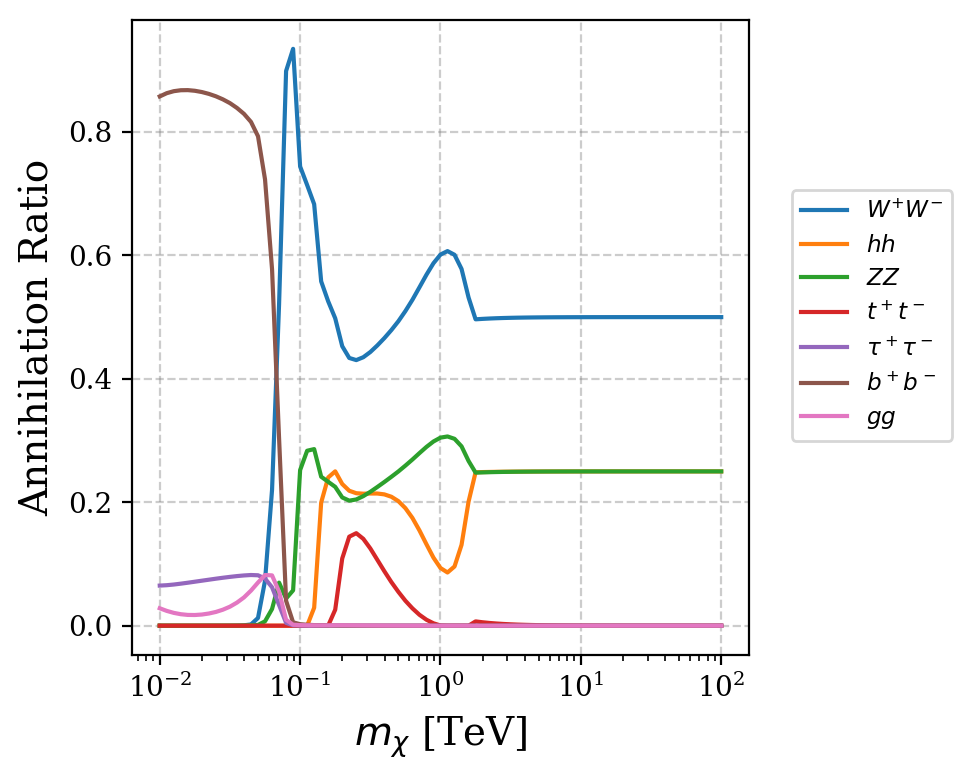

In [8]:

sigmavalues_dict = {}
testmassvalues = np.logspace(-2,2,81)
plt.figure(dpi=200, figsize=(5,4))

total_cross_sections = 0
for channel, sigmavfunc in partial_sigmav_interpolator_dictionary.items():
    total_cross_sections += sigmavfunc(testmassvalues, 0.1)
    sigmavalues_dict[channel] = sigmavfunc(testmassvalues, 0.1)
    

plt.plot(testmassvalues, sigmavalues_dict['W+W-']/total_cross_sections, label=r'$W^{+}W^{-}$')
plt.plot(testmassvalues, sigmavalues_dict['HH']/total_cross_sections, label=r'$hh$')
plt.plot(testmassvalues, sigmavalues_dict['ZZ']/total_cross_sections, label=r'$ZZ$')
plt.plot(testmassvalues, sigmavalues_dict['tt']/total_cross_sections, label=r'$t^+t^-$')

plt.plot(testmassvalues, sigmavalues_dict['tau+tau-']/total_cross_sections, label=r'$\tau^+\tau^-$')
plt.plot(testmassvalues, sigmavalues_dict['bb']/total_cross_sections, label=r'$b^+b^-$')
plt.plot(testmassvalues, sigmavalues_dict['gg']/total_cross_sections, label=r'$gg$')


plt.ylabel('Annihilation Ratio', size=14)
plt.xlabel(r'$m_\chi$ [TeV]', size=14)

plt.grid(axis='both', alpha=0.4, c='grey', ls='--')


plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 0.75), fontsize='small')
plt.tight_layout()
plt.savefig("Figures/SS_DM_BFs.pdf")
plt.show()

    


## Total Z_2 scalar singlet dark matter spectra

Once we have the fraction every final state to get the total dark matter spectra we need the spectra for each channel. The values for the individual flux of every channel are stored within the `griddata` folder of the package along with the mass and log10x values that created them. 

If a channel exists in darkSUSY but not these tables then we simply say that the spectral flux will be 0 with a lambda function, and we also take the sqrt root of the channels to later square to enforce positive definite-ness.

In [9]:
sqrtchannelfuncdictionary = {}


log10xvals = np.load(single_channel_spectral_data_path+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")
massvalues = np.load(single_channel_spectral_data_path+f"/griddata/massvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in list(darkSUSY_to_PPPC_converter.keys()):
    try:
        gammapychannel = darkSUSY_to_PPPC_converter[darkSUSYchannel]
        
        tempspectragrid = np.load(
            single_channel_spectral_data_path+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
        
        # Square root is to preserve positivity during interpolation
        sqrtchannelfuncdictionary[darkSUSYchannel] = interpolate.RegularGridInterpolator(
            (np.log10(massvalues/1e3), log10xvals), 
            np.sqrt(np.array(tempspectragrid)), 
            method='cubic', bounds_error=False, fill_value=0)
    except:
        sqrtchannelfuncdictionary[darkSUSYchannel] = lambda inputs: inputs[0]*0 # inputs should be a tuple or list of log_10(mass) in TeV and log_10(x)


Let's make a handy function to combine the differential cross-sections and the single channel spectra.

In [10]:
from scipy.special import logsumexp


def construct_spectra(energy,massval):    
    logspectra = -np.inf

    for channel in sqrtchannelfuncdictionary.keys():
        logspectra = np.logaddexp(
            logspectra, 
            np.log(
                partial_sigmav_interpolator_dictionary[channel](massval, 0.1)\
                    *(sqrtchannelfuncdictionary[channel]((np.log10(massval), 
                    np.log10(energy)-np.log10(massval))))**2))
    
    return logspectra


Testing this function out we find.

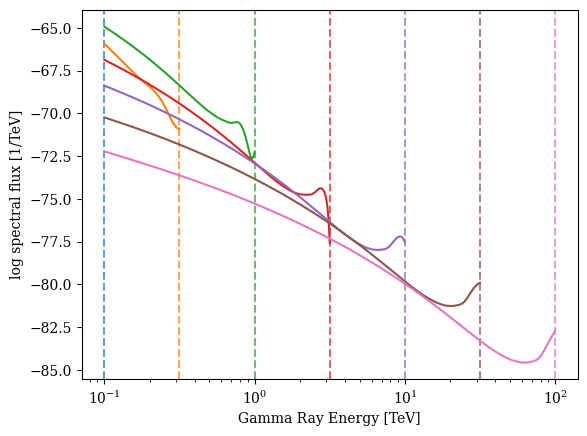

In [11]:
massval_list = np.logspace(-1,2,7)

plt.figure()
for massval in massval_list:
    plotstuff = plt.plot(energy_true_axis,construct_spectra(energy_true_axis, massval)) 
    plt.axvline(massval, c=plotstuff[0].get_color(), ls='--', alpha=0.7)
plt.xscale('log')
plt.xlabel('Gamma Ray Energy [TeV]')
plt.ylabel('log spectral flux [1/TeV]')
plt.show()

## Differential J factors

The CTA will also collect sky position data, so we need an angular distribution for the dark matter. For this we will use the differential J factors for a dark matter density profile. For the reason why we use the differential J factors please read the release paper for the code. 

For now we will use the Einasto dark matter density profile and using `Gammapy` to calculate the differential J factors. For further detail on how this calculation works please head over to the Gammapy documentation found [here](https://docs.gammapy.org/dev/api/gammapy.astro.darkmatter.JFactory.html).

In [12]:
from gammabayes.utils import convertlonlat_to_offset
from gammabayes.likelihoods.irfs import log_aeff

profile = profiles.EinastoProfile()

# Adopt standard values used in HESS
profiles.DISTANCE_GC = 8.5 * u.kpc
profiles.LOCAL_DENSITY = 0.39 * u.Unit("GeV / cm3")

profile.scale_to_local_density()

central_position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")

# Presuming even spacings
geom = WcsGeom.create(skydir=central_position, 
                    binsz=(np.diff(longitudeaxistrue)[0], np.diff(latitudeaxistrue)[0]),
                    width=(np.ptp(longitudeaxistrue)+np.diff(longitudeaxistrue)[0], 
                        np.ptp(latitudeaxistrue)+np.diff(latitudeaxistrue)[0]),
                    frame="galactic")


jfactory = JFactory(
    geom=geom, profile=profile, distance=profiles.DMProfile.DISTANCE_GC
)

We convert the differential J factor to 'TeV^2/(cm^5 sr)', and then store the values in `diff_j_factors_values`.

In [13]:
diff_j_factors_values = jfactory.compute_differential_jfactor().to(u.TeV**2/(u.cm**5*u.sr))
diff_j_factors_values = (diff_j_factors_values.value)

Let's have a look at these factors.

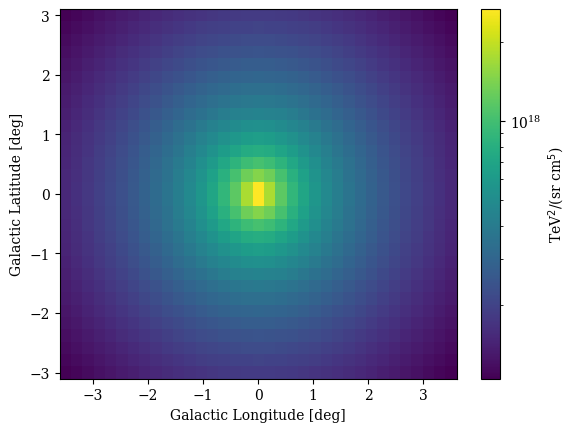

In [14]:
plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, diff_j_factors_values, norm=LogNorm())
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')
plt.colorbar(label=r'TeV$^2$/(sr cm$^5$)')
plt.show()

## Effective Area

Okay so we have the energy distribution and angular distribution...but the tutorial is still going? We remind the reader that we have not accounted for what the __CTA__ will observe, as aspects of the telescope will mean that some fluxes are less likely to be seen while others are more likely to be detected.

This is contained within the effective area of the telescope. `GammaBayes` has a useful wrapper of the function as it appears in `Gammapy` that outputs the log of the effective area instead of the straight effective area to minimise computational instability problems for later analysis.

Let's construct a grid of values as we did for the differential J factors and look a slice of the result although if you've already looked at the astrophysical background tutorial it should look very familiar.

In [15]:
energy_true_axis_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh = np.meshgrid(energy_true_axis, longitudeaxistrue, latitudeaxistrue, indexing='ij')

log_aeffvals = log_aeff(energy_true_axis_mesh.flatten(), longitudeaxistrue_mesh.flatten(), latitudeaxistrue_mesh.flatten()).reshape(energy_true_axis_mesh.shape)

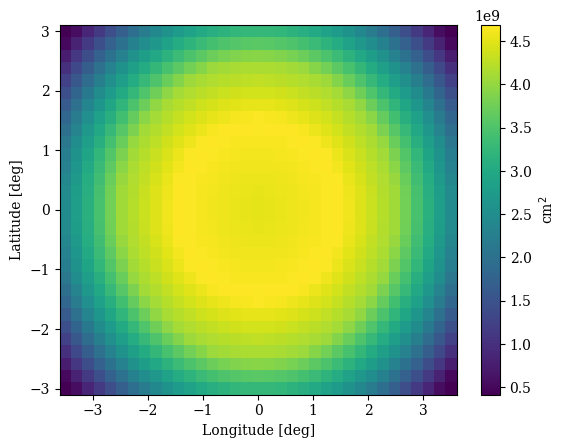

In [21]:
from gammabayes.utils import iterate_logspace_integration, logspace_riemann


plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(log_aeffvals[150, :,:].T))
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.colorbar(label=r'cm$^2$')
plt.show()

## The full picture

We then combine all these by mutliplying them all together, or rather add them because they are (will be ) in log-space.

In [22]:
# For a mass of 10 TeV
spectralvals = construct_spectra(energy_true_axis, 10)
full_SS_prior_grid = spectralvals[:, None, None]+np.log(diff_j_factors_values.T[None,:,:])+log_aeffvals


Now let's look at the full model.

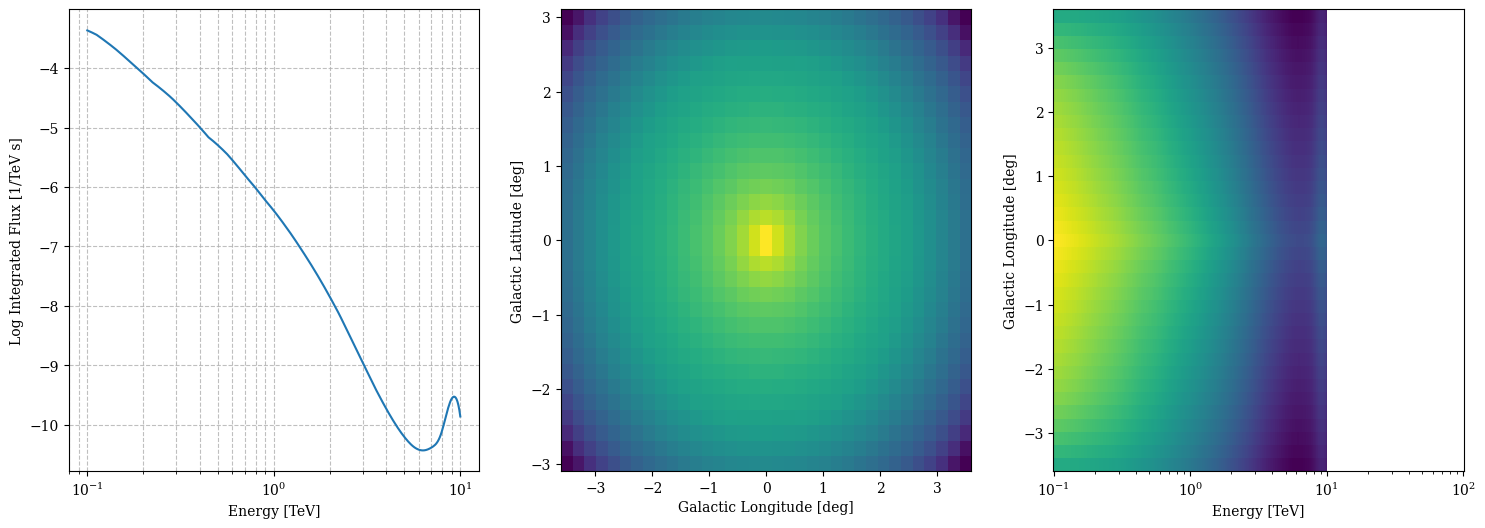

In [30]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(energy_true_axis, iterate_logspace_integration(full_SS_prior_grid, axes=[longitudeaxistrue, latitudeaxistrue], axisindices=[1,2]))
plt.xlabel(r'Energy [TeV]')
plt.ylabel('Log Integrated Flux [1/TeV s]')
plt.xscale('log')
plt.grid(True, which='both', ls='--', alpha=0.8)

plt.subplot(132)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logspace_riemann(full_SS_prior_grid, x=energy_true_axis, axis=0).T)
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')


plt.subplot(133)
plt.pcolormesh(energy_true_axis, longitudeaxistrue, logspace_riemann(full_SS_prior_grid, x=latitudeaxistrue, axis=2).T,)
plt.xscale('log')
plt.ylabel('Galactic Longitude [deg]')
plt.xlabel(r'Energy [TeV]')
plt.show()


## Using GammaBayes

In `GammaBayes` all this is taken care of with the `SS_DM_dist` module which is typically used as follows.

In [28]:
from gammabayes.dark_matter import SS_DM_dist

dm_dist_constructor = SS_DM_dist(longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, density_profile='einasto', ratios=False)
dm_dist_constructor_logfunc = dm_dist_constructor.func_setup() # Creates a function that returns the log of the flux of the full model

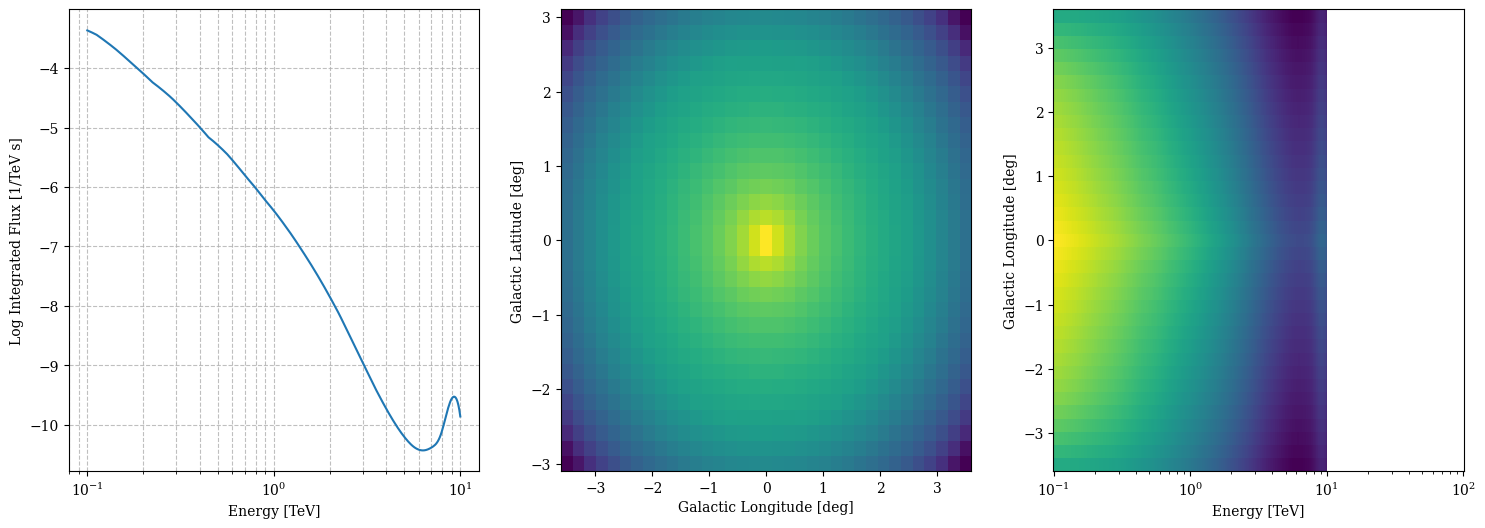

In [29]:

#                                                                                                                       For a mass of 10 TeV
logflux_constructor_vers = dm_dist_constructor_logfunc(energy_true_axis_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh, energy_true_axis_mesh*0+10)

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(energy_true_axis, iterate_logspace_integration(logflux_constructor_vers, axes=[longitudeaxistrue, latitudeaxistrue], axisindices=(1,2)))
plt.xlabel(r'Energy [TeV]')
plt.xscale('log')
plt.grid(True, which='both', ls='--', alpha=0.8)
plt.ylabel('Log Integrated Flux [1/TeV s]')

plt.subplot(132)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logspace_riemann(logflux_constructor_vers, x=energy_true_axis, axis=0).T)
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')


plt.subplot(133)
plt.pcolormesh(energy_true_axis, longitudeaxistrue, logspace_riemann(logflux_constructor_vers, x=latitudeaxistrue, axis=2).T,)
plt.ylabel('Galactic Longitude [deg]')
plt.xlabel(r'Energy [TeV]')
plt.xscale('log')
plt.show()

And then, if you want to use a cored profile such as Burkert or Moore one can simply give them as the density profile within the class instance.

In [32]:
burkert_dm_dist_constructor = SS_DM_dist(longitudeaxis=longitudeaxistrue, latitudeaxis=latitudeaxistrue, density_profile='burkert', ratios=False)
burkert_dm_dist_constructor_logfunc = burkert_dm_dist_constructor.func_setup()

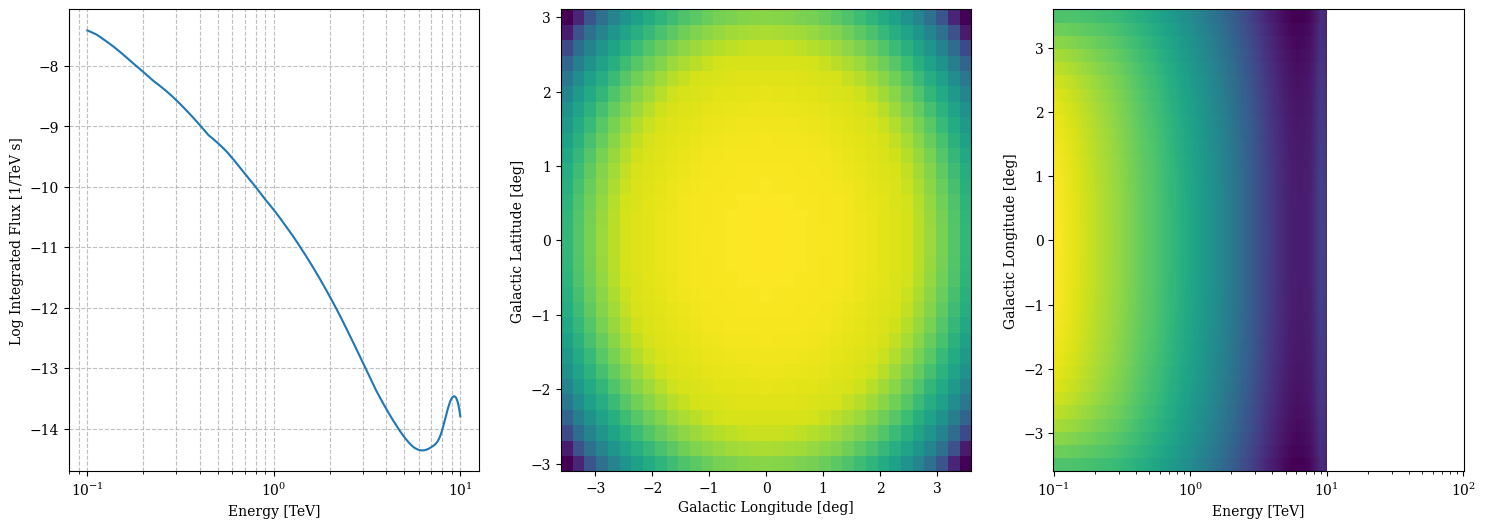

In [33]:

#                                                                                                                       For a mass of 10 TeV
burkert_logflux_constructor_vers = burkert_dm_dist_constructor_logfunc(energy_true_axis_mesh, longitudeaxistrue_mesh, latitudeaxistrue_mesh, energy_true_axis_mesh*0+10)

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(energy_true_axis, iterate_logspace_integration(burkert_logflux_constructor_vers, axes=[longitudeaxistrue, latitudeaxistrue], axisindices=(1,2)))
plt.xlabel(r'Energy [TeV]')
plt.xscale('log')
plt.grid(True, which='both', ls='--', alpha=0.8)
plt.ylabel('Log Integrated Flux [1/TeV s]')

plt.subplot(132)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logspace_riemann(burkert_logflux_constructor_vers, x=energy_true_axis, axis=0).T)
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')


plt.subplot(133)
plt.pcolormesh(energy_true_axis, longitudeaxistrue, logspace_riemann(burkert_logflux_constructor_vers, x=latitudeaxistrue, axis=2).T,)
plt.ylabel('Galactic Longitude [deg]')
plt.xlabel(r'Energy [TeV]')
plt.xscale('log')
plt.show()